In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

# Markov chains

## 10.1.1 Cambridge weather simulator

In [4]:
P = cambridge_weather_transitions = np.array([[.2,.6,.2], [.3,0,.7], [0,.5,.5]])
assert np.allclose(np.sum(P,axis=1), np.ones(len(P)))

def rweather(initial_state):
    x = initial_state
    while True:
        yield x
        x = np.random.choice(3, p=P[x])

x = rweather(initial_state=2) # x is an infinite-lazy-list object
for n in range(5): 
    print("On day", n, "weather is", next(x))

On day 0 weather is 2
On day 1 weather is 1
On day 2 weather is 2
On day 3 weather is 2
On day 4 weather is 1


## 10 / 10.1.4 Epidemic model

We can parameterize the epidemic as
$$
X_{n+1} = X_n + \operatorname{Pois}(\lambda X_n) - \operatorname{Bin}(X_n,p)
$$
or equivalently as
$$
X_{n+1} = X_n + \operatorname{Pois}(r X_n/d) - \operatorname{Bin}(X_n,1/d)
$$

In [ ]:
# This code uses a random number stream (ω), for reproducibility.
# (See remark in section 10.0.)

def repidemic(x0,r,d,n,ω):
    # Simulate n timesteps
    x = x0
    res = [x]
    for _ in range(n-1):
        x = x + ω.poisson(x*r/d) - ω.binomial(x, 1/d)
        res.append(x)
    return np.array(res)

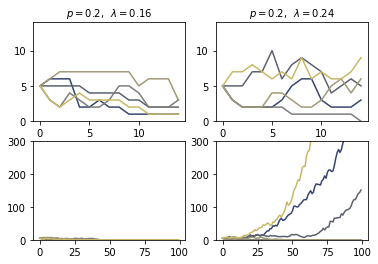

In [13]:
# Simulate 5 epidemics each, at two different parameter values
θ = [(0.8,5),(1.2,5)]
M = 5
rng = np.random.default_rng(1642)
xss = [[repidemic(5,r=r,d=d,n=1000,ω=np.random.default_rng(rng.integers(2000))) for _ in range(M)] for (r,d) in θ]

# Plot them
cmap = plt.get_cmap('cividis')
cols = [cmap(c) for c in np.linspace(.2,.8,M)]

fig,axes = plt.subplots(2,2, figsize=(6,4))
for xs,(r,d,),(ax1,ax2) in zip(xss,θ,axes.T):
    for x,c in zip(xs, cols):
        T = 15
        ax1.plot(np.arange(15), x[:15], color=c)
        ax2.plot(np.arange(100), x[:100], color=c)
        ax1.set_title(f'$p={1/d},\;\;λ={r/d}$', fontsize=10)
axes[0,0].sharex(axes[0,1])
axes[1,0].sharex(axes[1,1])
axes[0,0].sharey(axes[0,1])
axes[1,0].sharey(axes[1,1])
axes[0,0].set_ylim([0,14])  
axes[1,0].set_ylim([0,300])
        
plt.show()

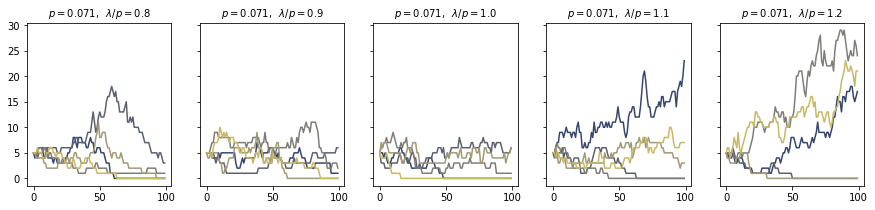

In [15]:
# Simulate 5 epidemics each, at five different parameter values
d = 14
rs = [.8,.9,1,1.1,1.2]
M = 5
rng = np.random.default_rng(1621)
xss = [[repidemic(5,r=r,d=14,n=1000,ω=np.random.default_rng(rng.integers(2000))) for _ in range(M)] for r in rs]

cmap = plt.get_cmap('cividis')
cols = [cmap(c) for c in np.linspace(.2,.8,M)]

fig,axes = plt.subplots(1,len(rs), figsize=(len(rs)*3,3), sharex=True, sharey=True)
for xs,r,ax in zip(xss,rs,axes):
    for x,c in zip(xs, cols):
        ax.plot(np.arange(100), x[:100], color=c)
        ax.set_title(f'$p={1/d:.3f},\;\;λ/p={r:.1f}$', fontsize=10)
        
plt.show()

## 10.3.2, 10.3.3 Markov model for words, and trigram model

In [30]:
import urllib
import re
import collections

url = "http://norvig.com/ngrams/shakespeare.txt"
with urllib.request.urlopen(url) as f:
    txt = f.read().decode('utf8') 

# Clean up some spaces around punctuation etc.
words = ' '.join(txt.split())
words = re.sub(r'[.,:!?,;] ',' ', words)
words = words.split()
words = [w.lower() for w in words]

# Define a random function for generating the next word, based on counts
next_word_count = collections.defaultdict(lambda: collections.defaultdict(int))
for i in range(len(words)-2):
    u,v = words[i], words[i+1]
    next_word_count[u][v] += 1
    
def rword(u, counts, ω):
    wc = counts[u].items()
    w,c = [w for w,_ in wc], np.array([c for _,c in wc])
    return ω.choice(w, p=c/np.sum(c))
    
rng = np.random.default_rng(1619)
x = ['to']
for _ in range(16):
    x.append(rword(x[-1], counts=next_word_count, ω=rng))
    
' '.join(x)

'to foreign princes lie in your blessing god who shall have the prince of rome the other'

In [36]:
# For every pair of words, count the frequency of what comes next
trigram_word_count = collections.defaultdict(lambda: collections.defaultdict(int))
for i in range(len(words)-3):
    u,v,w = words[i:i+3]
    trigram_word_count[(u,v)][w] += 1
    
rng = np.random.default_rng(1619)
y = [('to','be')]

for _ in range(16):
    next_word = rword(y[-1], counts=trigram_word_count, ω=rng)
    y.append((y[-1][-1], next_word))

x = [u for u,v in y]
' '.join(x)

'to be wind-shaken we will be glad to receive at once for the example of thousands that'

## 11.0.2 Active Users model

Model: $X_{n+1} = X_n + \operatorname{Poisson}(\lambda) - \operatorname{Bin}(X_n, 1/d)$

The Poisson term represents newly arrived users, and the Binomial term represents departures.

In [44]:
def rusers(x0,λ,d,ω):
    x = x0
    while True:
        yield x
        x = x + ω.poisson(λ) - ω.binomial(x, 1/d)

# Reproducibility setup
T = 2
rng = np.random.default_rng(1618)
seeds = rng.integers(1000, size=T)

# Run them each for 2000 timesteps
H = 2000
xs = [rusers(5, λ=1.2, d=14, ω=np.random.default_rng(s)) for s in seeds]
xs = [[next(r) for _ in range(H)] for r in xs]

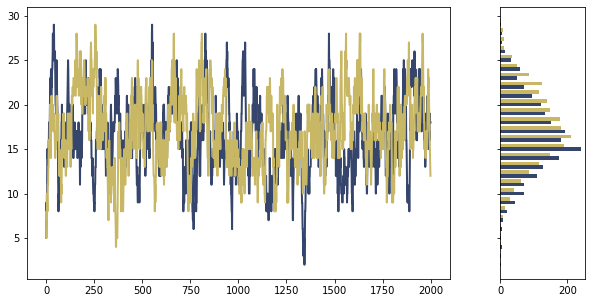

In [45]:
fig,(ax,ax2) = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios':[1,.2]}, sharey=True)
cmap = plt.get_cmap('cividis')
cols = [cmap(c) for c in np.linspace(.2,.8,T)]

for i,(x,c) in enumerate(zip(xs, cols)):
    ax.plot(np.arange(H), x, color=c, linewidth=2)
    counts = pandas.Series(x).value_counts()
    ax2.barh(counts.index+0.8*i/T, counts.values, color=c, height=0.8/T)

plt.show()

## 11.1.1 Multi-step transition probabilities

In [37]:
P = cambridge_weather_transitions = np.array([[.2,.6,.2], [.3,0,.7], [0,.5,.5]])

In [38]:
# two-step transition probabilities
P @ P

array([[0.22, 0.22, 0.56],
       [0.06, 0.53, 0.41],
       [0.15, 0.25, 0.6 ]])

In [39]:
# 100-step transition probabilities
# Note: the probability you end up in state j converges to π_j, the stationary distribution, after very many steps
np.linalg.matrix_power(P, 100)

array([[0.12820513, 0.34188034, 0.52991453],
       [0.12820513, 0.34188034, 0.52991453],
       [0.12820513, 0.34188034, 0.52991453]])

## 11.2.1 Hitting probabilities
Random walk on a directed graph. State 5 is an absorbing state (i.e. once you get there you stay there). Let $\pi_x$ be the probability that, starting from state $x$, you hit state 0. (This is less than one, because you might get trapped in 5 before you hit 0.) The equations for hitting probability are ...

$$
\begin{align}
\pi_0 &= 1\\
\pi_5 &= 0\\
\pi_x &= \sum_y P_{x y} \pi_y = [P\pi]_x \quad\text{for }x=1,\dots,4
\end{align}
$$

In [40]:
# Adjacency matrix (including a link from state 5 back to itself)
E = np.array([[0,1,0,0,1,0],
              [1,0,0,0,1,1],
              [0,1,0,1,0,0],
              [0,0,1,0,1,1],
              [0,0,0,1,0,0],
              [0,0,0,0,0,1]])
# Transition matrix
P = E / E.sum(axis=1)[:,np.newaxis]
assert np.allclose(P.sum(axis=1), 1)

# Equations for hitting probability
Q = P.copy()
Q[0,:] = 0
Q[5,:] = 0
b = np.zeros(6)
b[0] = 1
π = np.linalg.solve(np.eye(6) - Q, b)
π

array([1.   , 0.375, 0.25 , 0.125, 0.125, 0.   ])

## 11.4.1 Stationary distribution

The stationary distribution solves
$$
\pi = \pi P \quad\text{and}\quad \pi\cdot1=1
$$
The first equation can be rewritten $\pi(P-I)=(P-I)^T\pi=0$.

In [43]:
P = cambridge_weather_transitions
A = np.concatenate([(P-np.eye(3)).T, [[1,1,1]]])
π = np.linalg.lstsq(A, [0,0,0,1], rcond=None)[0]
π

# There is a silly numpy FutureWarning, and rcond=None suppresses it.

array([0.12820513, 0.34188034, 0.52991453])